In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.lines import Line2D
import os
from pathlib import Path

# Memory spaces
- Global vs local memory
- Different strides between elements
- Read in global memory and write in:
    - Global mem
    - Local mem
- No computation

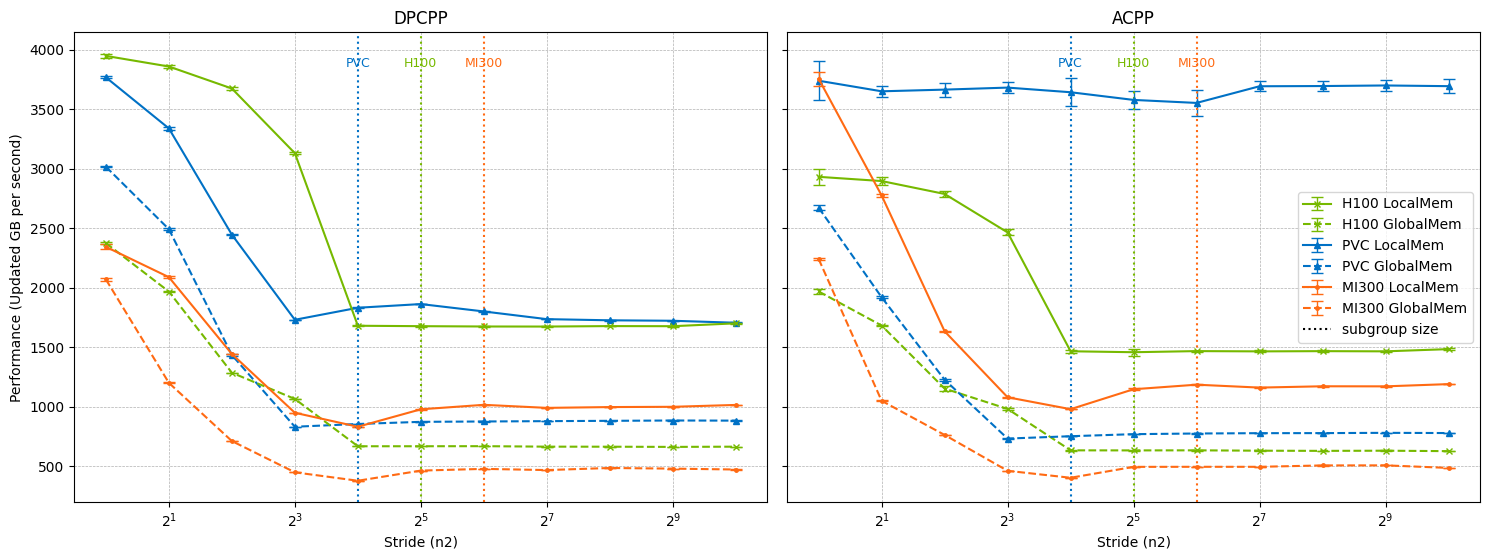

In [2]:


# Configuration
folder = "memory-spaces/"
compilers = ["dpcpp", "acpp"]
hardware_colors = {
    "h100": "#76B900",  # NVIDIA green
    "pvc": "#0071C5",   # Intel blue
    "mi300": "#FF6A13",
}

subgroup_sizes = {
    "h100": 32,   # NVIDIA warp
    "pvc": 16,    # Intel subgroup
    "mi300": 64
}

hardware_markers = {
    "h100": 'x',  # small cross
    "pvc": '^',   # triangle up
    # Add more markers here as needed
}

# Set up subplots: one per compiler
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for ax, compiler in zip(axes, compilers):
    file_pattern = f"{folder}/{compiler}_50_reps_*.json"
    json_files = glob.glob(file_pattern)

    all_strides = set()  # Collect all strides for proper x-axis ticks

    for filepath in json_files:
        hardware = os.path.splitext(os.path.basename(filepath))[0].split("_")[-1].lower()
        color = hardware_colors.get(hardware, 'gray')

        with open(filepath) as f:
            data = json.load(f)

        df = pd.DataFrame(data["benchmarks"])
        all_strides.update(df["n2"].unique())  # Collect strides

        means = df[df["aggregate_name"] == "mean"].copy()
        stddevs = df[df["aggregate_name"] == "stddev"].copy()

        merge_keys = ["run_name", "per_family_instance_index"]
        merged = pd.merge(
            means,
            stddevs[merge_keys + ["bytes_per_second"]],
            on=merge_keys,
            suffixes=("", "_stddev")
        )

        merged["mem_type"] = merged["name"].apply(lambda x: "LocalMem" if "LocalMem" in x else "GlobalMem")
        merged["stride"] = merged["n2"]
        merged["GBps"] = merged["bytes_per_second"] / 1e9
        merged["GBps_stddev"] = merged["bytes_per_second_stddev"] / 1e9

        for mem_type, style in [("LocalMem", "-"), ("GlobalMem", "--")]:
            subset = merged[merged["mem_type"] == mem_type].sort_values("stride")
            label = f"{hardware.upper()} {mem_type}"

            ax.errorbar(
                subset["stride"],
                subset["GBps"],
                yerr=subset["GBps_stddev"],
                capsize=4,
                elinewidth=1,
                label=label,
                linestyle=style,
                marker=hardware_markers.get(hardware, '.'),
                markersize=5,
                color=color
            )

    # Set log2 scale and base-10 stride labels
    all_strides = sorted(all_strides)
    ax.set_xscale("log", base=2)
    # ax.set_xticklabels([str(np.log2(x)) for x in all_strides])
    # ax.set_xticks(all_strides)
    ax.set_xlabel("Stride (n2)")
    ax.set_title(f"{compiler.upper()}")

    # Add subgroup size marker lines
    for hw, size in subgroup_sizes.items():
        if hw in hardware_colors:
            ax.axvline(x=size, color=hardware_colors[hw], linestyle=":", linewidth=1.5)
            ax.text(
                size, ax.get_ylim()[1] * 0.95,
                f"{hw.upper()}",
                color=hardware_colors[hw],
                ha="center", va="top", fontsize=9
            )

    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Custom legend line for subgroup size marker
subgroup_legend = Line2D(
    [0], [0],
    color='black',
    linestyle=':',
    linewidth=1.5,
    label='subgroup size'
)
# Single legend on second subplot
axes[1].legend(handles=[*axes[1].get_legend_handles_labels()[0], subgroup_legend], loc="best")
# Shared Y label
axes[0].set_ylabel("Performance (Updated GB per second)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("memory-spaces.pdf")
plt.show()


# Operations order

- Copy/solve vs solve/copy
- 2 applications with 2 sizes each (total elements 2**28):
    - conv1d
        - k=1, l=8192, c=1, n=32768
        - k=3, l=2048, c=4, n=32768
    - lag advection
        - n0=32768, n1=8192, n2=1
        - n0=1024, n1=8192, n2=32


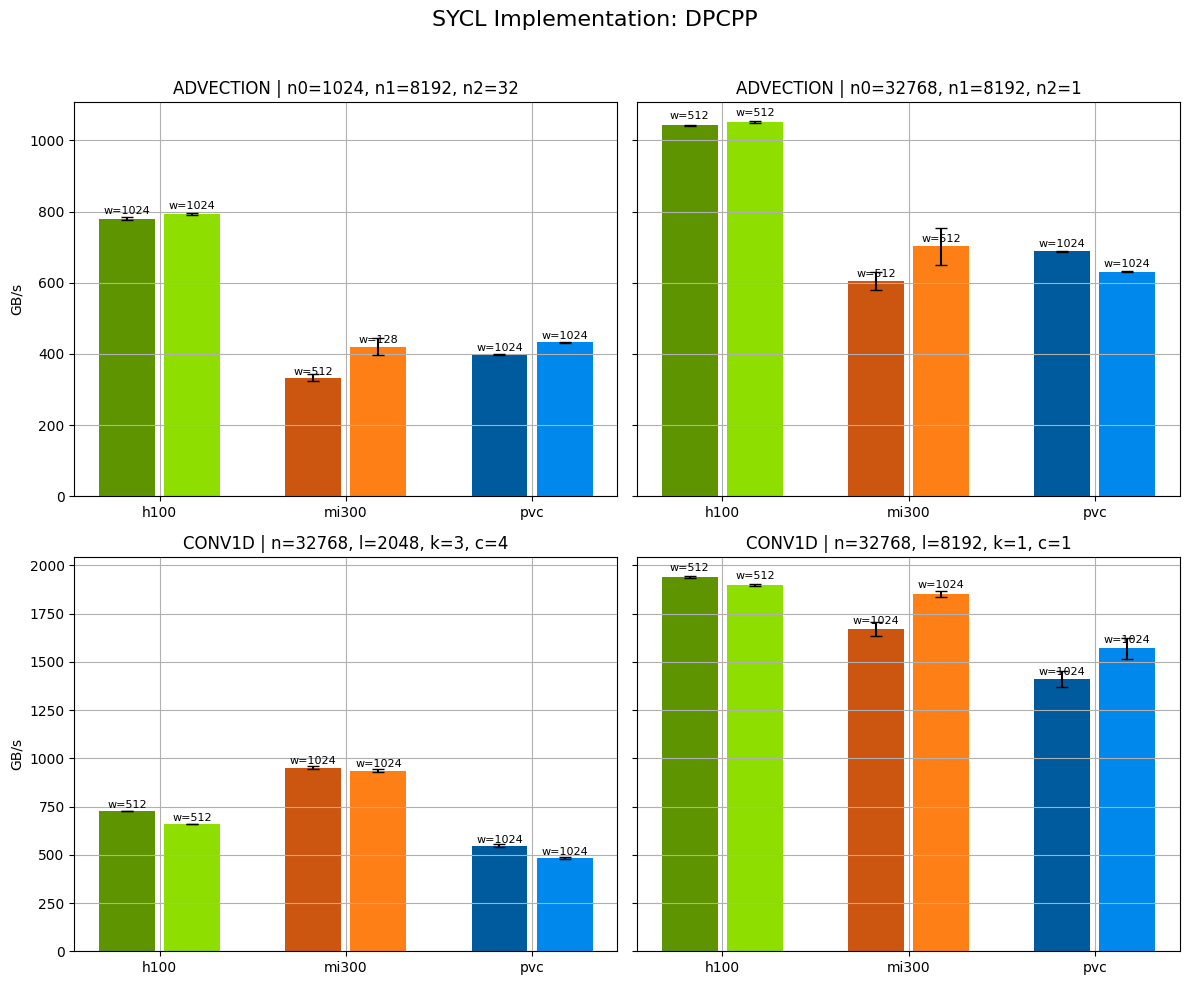

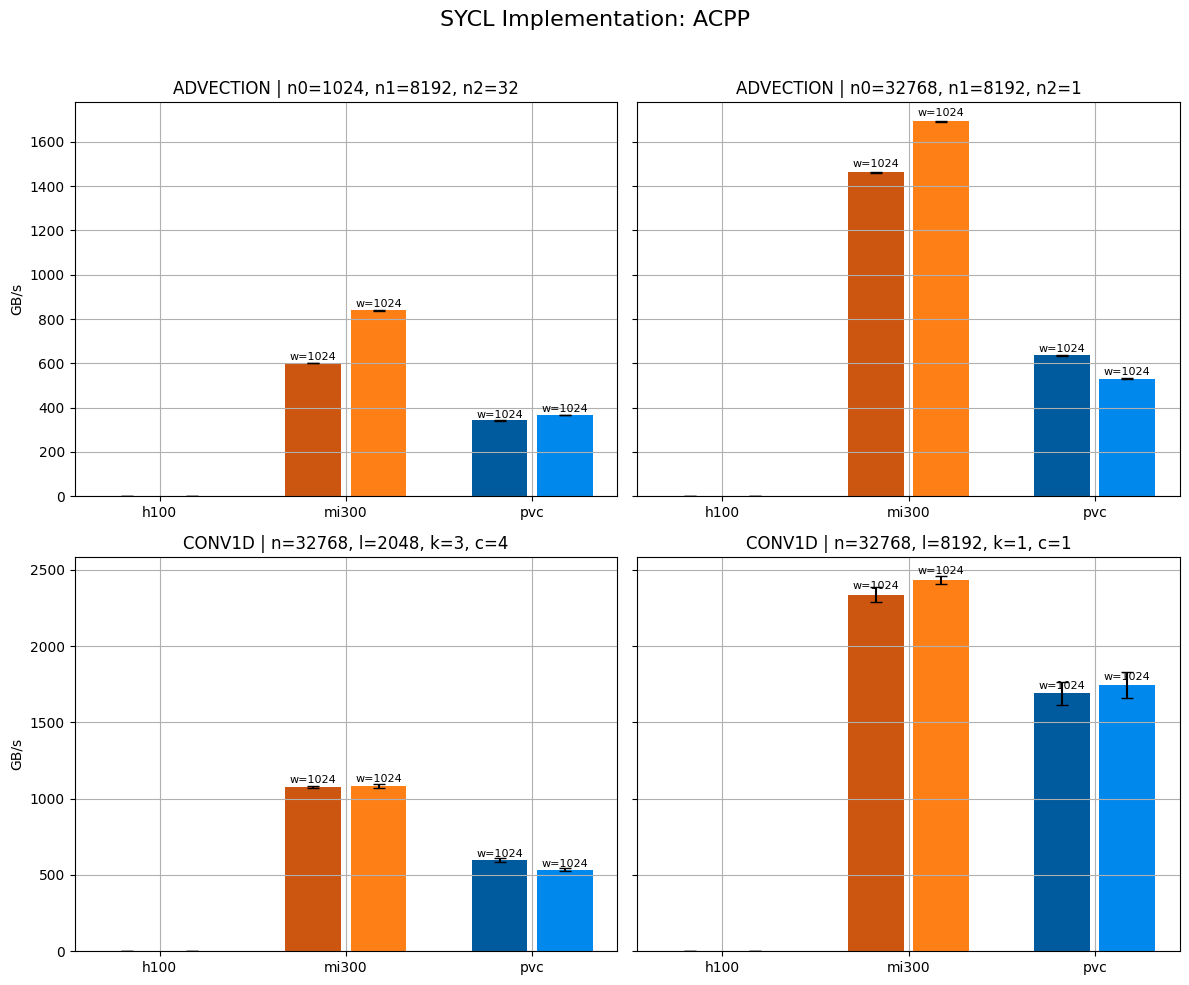

In [18]:
import os
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict

# Constants
base_dir = Path("/home/ac.amillan/source/phd-experiments/out/op-order")
orders = ["copy_solve", "solve_copy"]
hardware_list = ['h100', 'mi300', 'pvc']
hardware_colors = {'h100': '#76B900', 'mi300': '#FF6A13', 'pvc': '#0071C5'}
order_factors = {'copy_solve': 0.8, 'solve_copy': 1.2}

def adjust_color_brightness(hex_color, factor=1.0):
    rgb = mcolors.to_rgb(hex_color)
    adjusted = [min(1, max(0, c * factor)) for c in rgb]
    return mcolors.to_hex(adjusted)

# Load and parse benchmark data
records = []
for order in orders:
    order_path = base_dir / order
    for file in order_path.glob("*.json"):
        parts = file.stem.split("_")
        if len(parts) != 3:
            continue
        app, hw, impl = parts
        if impl not in ['dpcpp', 'acpp'] or hw not in hardware_list:
            continue
        with open(file) as f:
            data = json.load(f)
            benchmarks = data["benchmarks"]
            grouped = defaultdict(dict)
            for b in benchmarks:
                if "aggregate_name" in b:
                    run_id = b.get("run_name", b.get("name"))
                    grouped[run_id][b["aggregate_name"]] = b
            for run, agg in grouped.items():
                if "mean" in agg and "stddev" in agg:
                    b_mean = agg["mean"]
                    b_std = agg["stddev"]
                    if app == "conv1d":
                        n = int(float(b_mean.get("batch_size", 0)))
                        l = int(float(b_mean.get("input_length", 0)))
                        k = int(float(b_mean.get("kernel_size", 0)))
                        c = int(float(b_mean.get("channels", 0)))
                        size_str = f"n={n}, l={l}, k={k}, c={c}"
                    else:
                        n0 = int(float(b_mean.get("n0", 0)))
                        n1 = int(float(b_mean.get("n1", 0)))
                        n2 = int(float(b_mean.get("n2", 0)))
                        size_str = f"n0={n0}, n1={n1}, n2={n2}"
                    records.append({
                        "app": app,
                        "size": size_str,
                        "hardware": hw,
                        "impl": impl,
                        "order": order,
                        "mean_bps": b_mean["bytes_per_second"],
                        "std_bps": b_std["bytes_per_second"],
                        "w": b_mean.get("pref_wg_size", None)
                    })

df = pd.DataFrame(records)
df = df.loc[df.groupby(["app", "size", "hardware", "impl", "order"])["mean_bps"].idxmax()]

if df.empty:
    print("No benchmark data found.")
else:
    for impl in df["impl"].unique():
        impl_df = df[df["impl"] == impl]
        apps = ["advection", "conv1d"]
        app_sizes = {app: sorted(impl_df[impl_df["app"] == app]["size"].unique()) for app in apps}

        # Layout: rows = apps, cols = max number of sizes
        max_cols = max(len(s) for s in app_sizes.values())
        fig, axs = plt.subplots(nrows=2, ncols=max_cols, figsize=(6 * max_cols, 10), sharey='row')
        if max_cols == 1:
            axs = axs.reshape(2, 1)

        for row_idx, app in enumerate(apps):
            sizes = app_sizes[app]
            for col_idx, size in enumerate(sizes):
                ax = axs[row_idx, col_idx]
                size_df = impl_df[(impl_df["app"] == app) & (impl_df["size"] == size)]
                for i, hw in enumerate(hardware_list):
                    for j, order in enumerate(orders):
                        row = size_df.query(f"hardware == '{hw}' and order == '{order}'")
                        if not row.empty:
                            row = row.iloc[0]
                            mean_val = row['mean_bps'] / 1e9
                            std_val = row['std_bps'] / 1e9
                            w_val = row['w']
                        else:
                            mean_val = 0
                            std_val = 0
                            w_val = None
                        color = adjust_color_brightness(hardware_colors[hw], order_factors[order])
                        xpos = i + j * 0.35 - 0.175
                        ax.bar(xpos, mean_val, yerr=std_val, width=0.3, color=color, capsize=4)
                        if w_val is not None:
                            ax.text(xpos, mean_val + mean_val * 0.01, f"w={int(w_val)}",
                                    ha='center', va='bottom', fontsize=8)
                ax.set_title(f"{app.upper()} | {size}")
                ax.set_xticks(range(len(hardware_list)))
                ax.set_xticklabels(hardware_list)
                ax.grid()

            # Hide unused columns if any
            for empty_col in range(len(sizes), max_cols):
                fig.delaxes(axs[row_idx, empty_col])

        axs[0, 0].set_ylabel("GB/s")
        axs[1, 0].set_ylabel("GB/s")
        fig.suptitle(f"SYCL Implementation: {impl.upper()}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f"operations-order-structured-{impl}.pdf")
        plt.show()


# AdaptiveWg experiments

- 2 objectives to show:
    - no overhead compared to NDRange when d1 is contiguous
    - performance gain when d1 is non contiguous
- Only advection
- two sizes
    - n0=32768, n1=8192, n2=1
    - n0=1024, n1=8192, n2=32


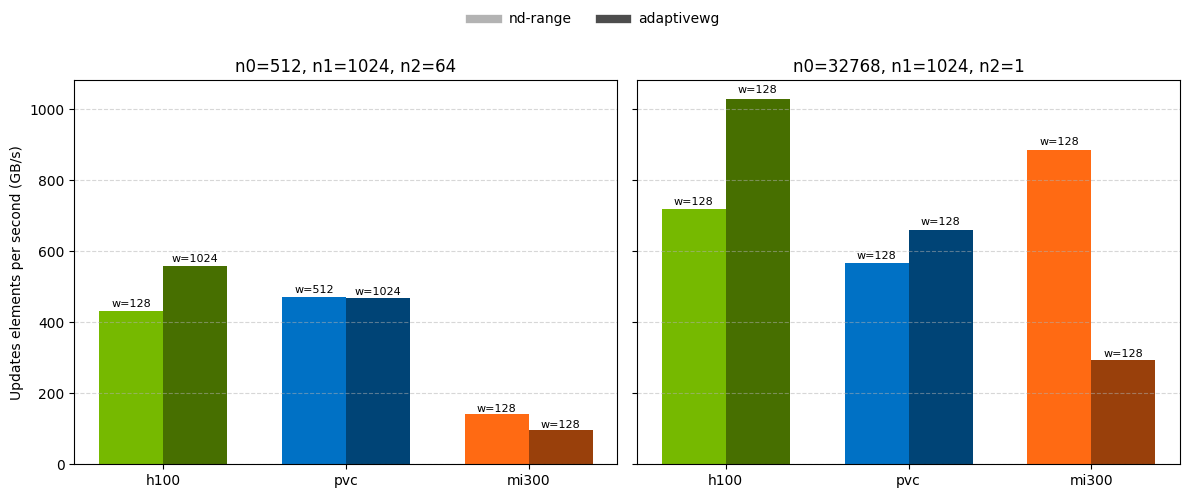

In [36]:
import json
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# hardware color mapping
hw_colors = {
    'h100': '#76B900',
    'pvc': '#0071C5',
    'mi300': '#FF6A13'
}
shade_factor = 0.6

# load all JSONs in folder
data = []

for filepath in glob.glob('/home/ac.amillan/source/phd-experiments/out/adaptive-wg/advection_*_dpcpp.json'):
    fname = os.path.basename(filepath)
    hw = fname.split('_')[1]
    with open(filepath) as f:
        j = json.load(f)
    temp_data = []
    for b in j['benchmarks']:
        if b['aggregate_name'] == 'mean':
            temp_data.append({
                'hardware': hw,
                'n0': b['n0'],
                'n1': b['n1'],
                'n2': b['n2'],
                'kernel_id': int(b['kernel_id']),
                'bytes_per_second': b['bytes_per_second'],
                'stddev': None,
                'w': b.get('pref_wg_size', None)
            })
        elif b['aggregate_name'] == 'stddev':
            for entry in reversed(temp_data):
                if (entry['hardware'] == hw and
                    entry['n0'] == b['n0'] and
                    entry['n1'] == b['n1'] and
                    entry['n2'] == b['n2'] and
                    entry['kernel_id'] == int(b['kernel_id'])):
                    entry['stddev'] = b['real_time']
                    break
    data.extend(temp_data)

df = pd.DataFrame(data)
df = df.loc[df.groupby(['n0', 'n1', 'n2', 'hardware', 'kernel_id'])['bytes_per_second'].idxmax()]
sizes = df[['n0','n1','n2']].drop_duplicates().sort_values(['n0','n1','n2']).values

fig, axs = plt.subplots(1, len(sizes), figsize=(12, 5), sharey=True)

for ax, (n0, n1, n2) in zip(axs, sizes):
    df_size = df[(df.n0==n0) & (df.n1==n1) & (df.n2==n2)]
    hw_list = sorted(df_size['hardware'].unique(), key=lambda x: list(hw_colors).index(x))
    x = np.arange(len(hw_list))
    width = 0.35

    for i, hw in enumerate(hw_list):
        for k_id, offset in [(0, -width/2), (1, width/2)]:
            row = df_size[(df_size.hardware == hw) & (df_size.kernel_id == k_id)]
            if row.empty:
                continue
            row = row.iloc[0]
            y = row['bytes_per_second'] / 1e9
            yerr = row['stddev']
            w_val = row['w']
            base_color = hw_colors[hw]
            if k_id == 0:
                color = base_color
            else:
                rgb = np.array(mcolors.to_rgb(base_color))
                color = rgb * shade_factor
            ax.bar(x[i] + offset, y, width, color=color, yerr=yerr, capsize=3)
            ax.text(x[i] + offset, y + y * 0.01, f'w={int(w_val)}',
                    ha='center', va='bottom', fontsize=8)

    ax.set_xticks(x)
    ax.set_xticklabels(hw_list)
    ax.set_title(f'n0={int(n0)}, n1={int(n1)}, n2={int(n2)}')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

axs[0].set_ylabel('Updates elements per second (GB/s)')

# Grayscale legend for kernel types
custom_lines = [
    plt.Line2D([0], [0], color='0.7', lw=6, label='nd-range'),
    plt.Line2D([0], [0], color='0.3', lw=6, label='adaptivewg')
]
fig.legend(handles=custom_lines, loc='upper center', ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.92])
fig.savefig("adaptivewg-vs-ndrange.pdf")

# Adaptive wg new
plus de tailles

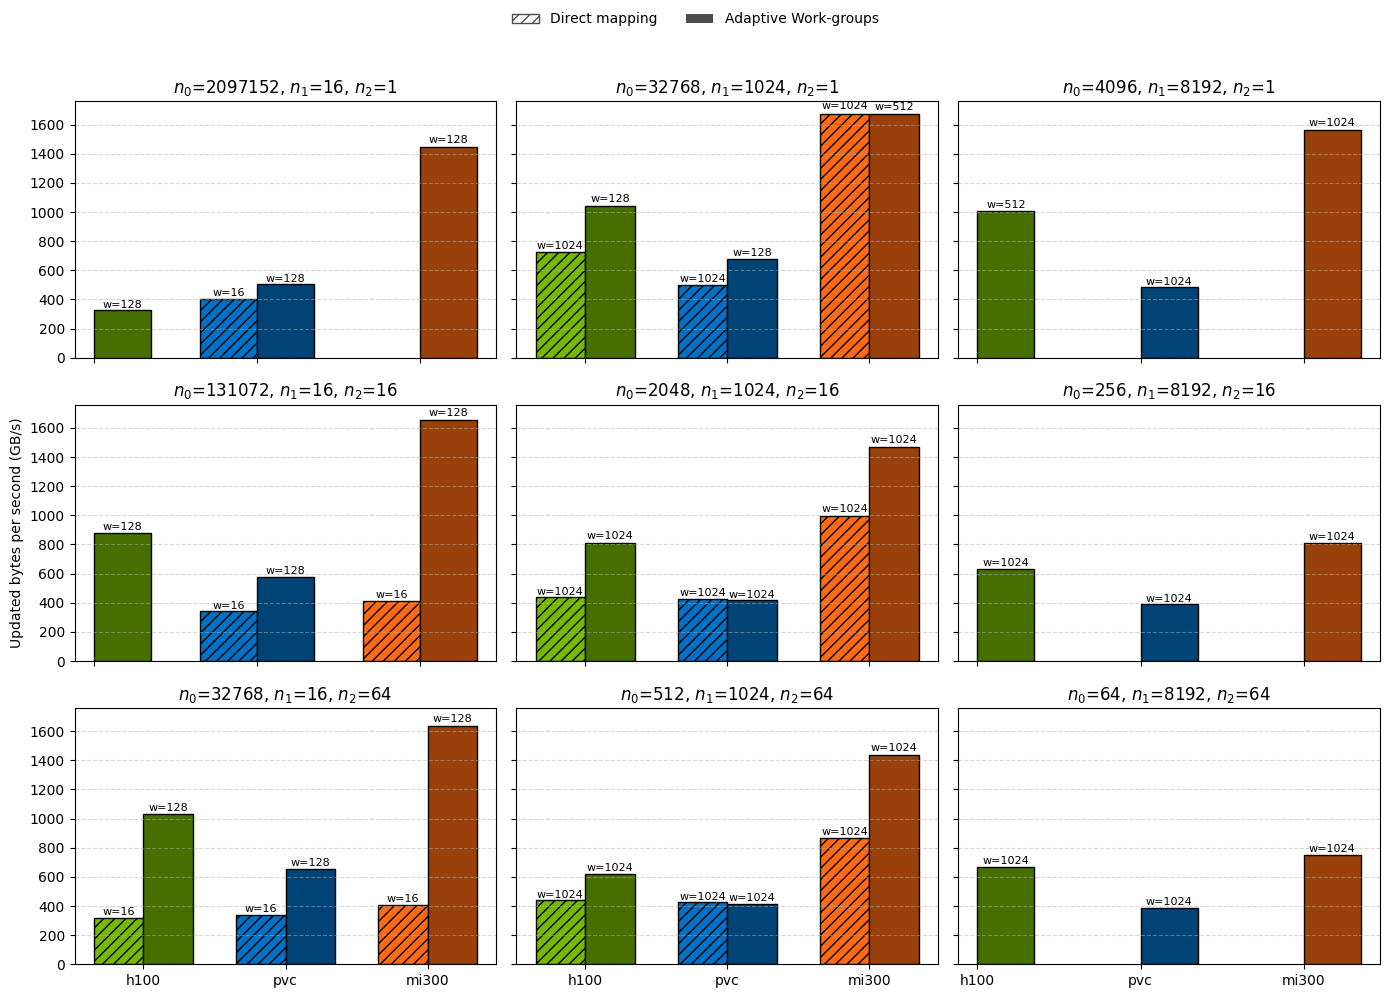

In [3]:
import json
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import math

# hardware color mapping
hw_colors = {
    'h100': '#76B900',
    'pvc': '#0071C5',
    'mi300': '#FF6A13'
}
shade_factor = 0.6

# load all JSONs in folder
data = []

for filepath in glob.glob('/home/ac.amillan/source/phd-experiments/out/adaptive-wg-new/advection_*.json'):
    fname = os.path.basename(filepath)
    parts = fname.split('_')
    hw = parts[1]  # e.g., h100

    with open(filepath) as f:
        j = json.load(f)
    temp_data = []
    for b in j['benchmarks']:
        if 'aggregate_name' not in b:
            continue

        kernel_id = b['kernel_id']

        if b['aggregate_name'] == 'mean':
            temp_data.append({
                'hardware': hw,
                'n0': b['n0'],
                'n1': b['n1'],
                'n2': b['n2'],
                'kernel_id': kernel_id,
                'bytes_per_second': b['bytes_per_second'],
                'stddev': None,
                'w': b.get('pref_wg_size', None)
            })
        elif b['aggregate_name'] == 'stddev':
            for entry in reversed(temp_data):
                if (entry['hardware'] == hw and
                    entry['n0'] == b['n0'] and
                    entry['n1'] == b['n1'] and
                    entry['n2'] == b['n2'] and
                    entry['kernel_id'] == kernel_id):
                    entry['stddev'] = b['real_time']
                    break
    data.extend(temp_data)

# df = pd.DataFrame(data)
# df = df.loc[df.groupby(['n0', 'n1', 'n2', 'hardware', 'kernel_id'])['bytes_per_second'].idxmax()]

# df = pd.DataFrame(data)
# # Séparer les deux types de kernel
# df_adaptive = df[df.kernel_id == 1]
# df_ndrange = df[(df.kernel_id == 0) & (df.w == df.n1)]
# # Pour adaptive, on garde la meilleure perf par config
# df_adaptive = df_adaptive.loc[df_adaptive.groupby(['n0', 'n1', 'n2', 'hardware'])['bytes_per_second'].idxmax()]
# # Pour ndrange, on garde uniquement w == n1, peu importe la perf
# # et on déduplique si besoin (on prend le premier si plusieurs)
# df_ndrange = df_ndrange.drop_duplicates(subset=['n0', 'n1', 'n2', 'hardware'])
# # Fusionner
# df = pd.concat([df_ndrange, df_adaptive])

df = pd.DataFrame(data)

# Séparer les deux types de kernel
df_adaptive = df[df.kernel_id == 1]
df_ndrange_all = df[df.kernel_id == 0]

# Pour adaptive, on garde la meilleure perf par config
df_adaptive = df_adaptive.loc[df_adaptive.groupby(['n0', 'n1', 'n2', 'hardware'])['bytes_per_second'].idxmax()]

# Pour ndrange : priorité à w == n1, sinon meilleure perf et on force w = n1
ndrange_rows = []
for (n0, n1, n2, hw), group in df_ndrange_all.groupby(['n0', 'n1', 'n2', 'hardware']):
    match = group[group.w == n1]
    if not match.empty:
        ndrange_rows.append(match.iloc[0])
    else:
        best = group.loc[group['bytes_per_second'].idxmax()].copy()
        best['w'] = n1  # override for display consistency
        ndrange_rows.append(best)

df_ndrange = pd.DataFrame(ndrange_rows)

# Fusionner
df = pd.concat([df_ndrange, df_adaptive])

# define custom plot layout
ordering = [
    (2**21, 16, 1), (2**15, 1024, 1), (2**12, 8192, 1),
    (2**17, 16, 16), (2**11, 1024, 16), (2**8, 8192, 16),
    (2**15, 16, 64), (2**9, 1024, 64), (2**6, 8192, 64)
]

fig, axs = plt.subplots(3, 3, figsize=(14, 10), sharey=True)
axs = axs.flatten()

for ax_idx, (ax, (n0, n1, n2)) in enumerate(zip(axs, ordering)):
    df_size = df[(df.n0==n0) & (df.n1==n1) & (df.n2==n2)]
    if df_size.empty:
        ax.axis('off')
        continue
    hw_list = sorted(df_size['hardware'].unique(), key=lambda x: list(hw_colors).index(x))
    x = np.arange(len(hw_list))
    width = 0.35

    for i, hw in enumerate(hw_list):
        for k_id, offset in [(0, -width/2), (1, width/2)]:
            row = df_size[(df_size.hardware == hw) & (df_size.kernel_id == k_id)]
            if row.empty:
                continue
            row = row.iloc[0]
            y = row['bytes_per_second'] / 1e9
            yerr = row['stddev']
            w_val = row['w']
            base_color = hw_colors[hw]
            color = base_color if k_id == 0 else np.array(mcolors.to_rgb(base_color)) * shade_factor
            hatch = '///' if k_id == 0 else None
            ax.bar(x[i] + offset, y, width, color=color, yerr=yerr, capsize=3, hatch=hatch, edgecolor='black')
            ax.text(x[i] + offset, y + y * 0.01, f'w={int(w_val)}',
                    ha='center', va='bottom', fontsize=8)

    ax.set_xticks(x)
    ax.set_xticklabels(hw_list)
    ax.set_title(f'$n_0$={int(n0)}, $n_1$={int(n1)}, $n_2$={int(n2)}')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

for ax in axs:
    ax.label_outer()
axs[3].set_ylabel('Updated bytes per second (GB/s)')

# Legend workaround with hatching
from matplotlib.patches import Patch
custom_lines = [
    Patch(facecolor='white', edgecolor='0.3', hatch='///', label='Direct mapping'),
    Patch(facecolor='0.3', label='Adaptive Work-groups')
]
fig.legend(handles=custom_lines, loc='upper center', ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.94])
fig.savefig("adaptivewg-vs-ndrange-all-sizes.pdf")


# Seq size

Impact of seqsize parameter on the batched dimensions.

### Seq size0

```cpp
static expe size0{32768, 1024, 1};
static bm_vec_t SEQ_SIZE0 = {1, 2, 4, 8, 16, 32, 64, 128, 256, 512};
static bm_vec_t SEQ_SIZE2 = {1};
```

### Seq size2

```cpp
static expe size1{1, 1024, 32768};
static bm_vec_t SEQ_SIZE0 = {1};
static bm_vec_t SEQ_SIZE2 = {1, 2, 4, 8, 16, 32, 64, 128, 256, 512};
```

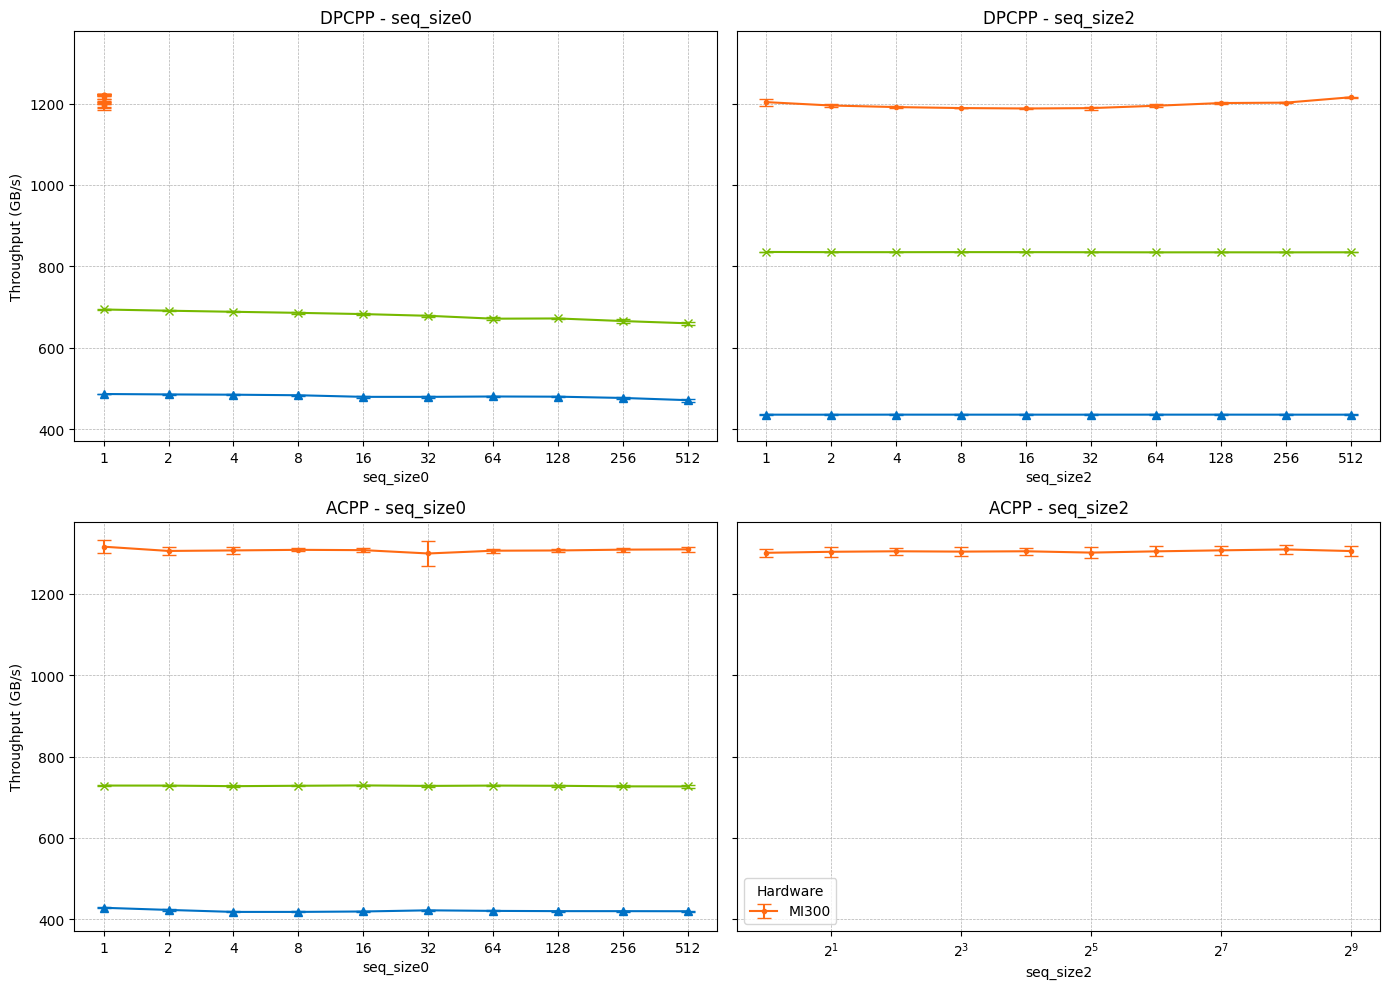

In [3]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

# Hardware config: color and marker
hardware_styles = {
    "h100": {"color": "#76B900", "marker": "x"},
    "pvc": {"color": "#0071C5", "marker": "^"},
    "mi300": {"color": "#FF6A13", "marker": "."}
}

def load_data(filename, seq_key):
    if not os.path.exists(filename):
        print(f"Warning: File not found: {filename}")
        return [], [], []
    with open(filename) as f:
        data = json.load(f)
    benchmarks = data["benchmarks"]
    means = [b for b in benchmarks if b["aggregate_name"] == "mean"]
    stddevs = {b["per_family_instance_index"]: b["real_time"] for b in benchmarks if b["aggregate_name"] == "stddev"}
    seq_sizes = [b[seq_key] for b in means]
    gbps = [b["bytes_per_second"] / 1e9 for b in means]
    errors = [
        stddevs.get(b["per_family_instance_index"], 0) / b["real_time"] * b["bytes_per_second"] / 1e9
        for b in means
    ]
    return seq_sizes, gbps, errors

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

compilers = ["dpcpp", "acpp"]
seq_keys = ["seq_size0", "seq_size2"]

for row, compiler in enumerate(compilers):
    for col, seq_key in enumerate(seq_keys):
        ax = axs[row, col]
        for hw in ["h100", "mi300", "pvc"]:
            filepath = f"seqsize/advection_{hw}_{compiler}_{seq_key}.json"
            x, y, yerr = load_data(filepath, seq_key)
            if not x:
                continue
            style = hardware_styles[hw]
            ax.errorbar(x, y, yerr=yerr, fmt=style["marker"]+"-", capsize=5,
                        color=style["color"], label=hw.upper())
        ax.set_xscale('log', base=2)
        if x:
            ax.set_xticks(x)
            ax.set_xticklabels([str(int(v)) for v in x])
        ax.set_xlabel(f'{seq_key}')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        if col == 0:
            ax.set_ylabel('Throughput (GB/s)')
        ax.set_title(f'{compiler.upper()} - {seq_key}')
        if row == 1 and col == 1:
            ax.legend(title="Hardware")

plt.tight_layout()
plt.savefig("seqsize_2x2.pdf")
plt.show()


# Outer loop

Checking the scaling of the runtime when submitting sub-batches

```cpp
static expe s0{1, 512, 1};
static expe s1{2, 512, 1};
static expe s2{4, 512, 1};
static expe s3{8, 512, 1};
static expe s4{16, 512, 1};
static expe s5{32, 512, 1};
static expe s6{64, 512, 1};
static expe s7{128, 512, 1};
static expe s8{256, 512, 1};
static expe s9{512, 512, 1};
static expe s10{1024, 512, 1};
static expe s11{2048, 512, 1};
static expe s12{4096, 512, 1};
static expe s13{8192, 512, 1};
static expe s14{16384, 512, 1};
static expe s15{32768, 512, 1};
static expe s16{65536, 512, 1};
static expe s17{131072, 512, 1};
static expe s18{262144, 512, 1};
static expe s19{524288, 512, 1};
static expe s20{1048576, 512, 1};
static expe s21{2097152, 512, 1};
static expe s22{4194304, 512, 1};
static expe s23{8388608, 512, 1};
static expe s24{16777216, 512, 1};
// static expe s25{16777216*2, 512, 1};

static std::vector EXP_SIZES{
    s0, s1, s2, s3, s4, s5, s6, s7, s8, s9,
    s10, s11, s12, s13, s14, s15, s16, s17, s18, s19,
    s20, s21, s22, s23, s24
};
```

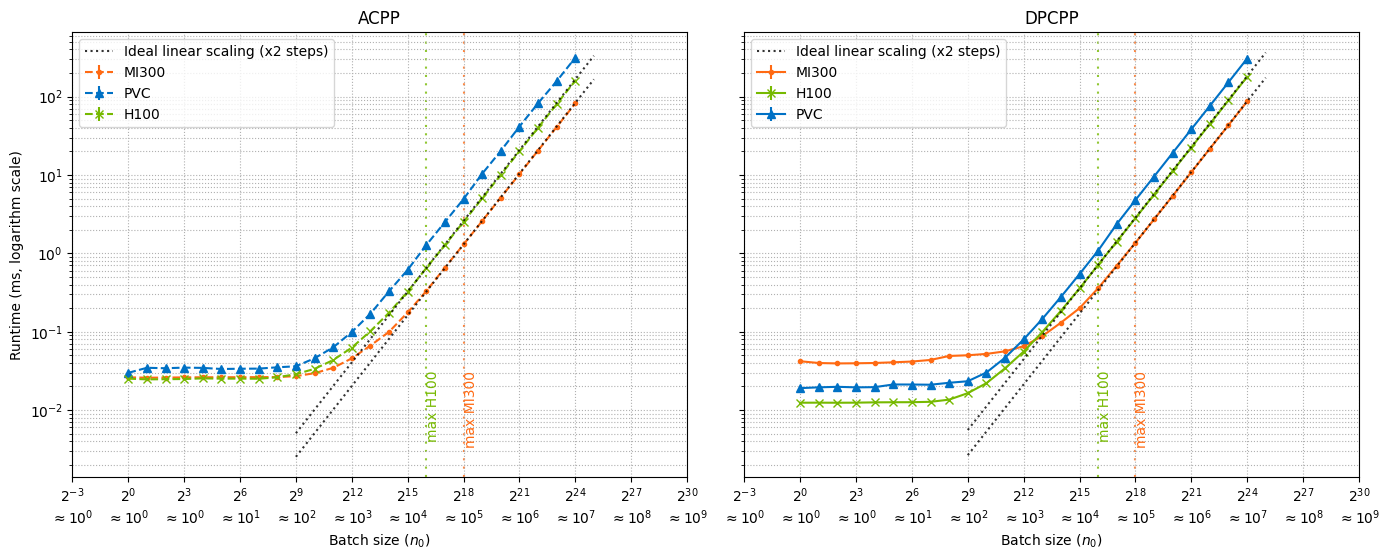

In [35]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.colors import to_rgba

# Constants
hardware_styles = {
    "h100": {"color": "#76B900", "marker": "x"},
    "mi300": {"color": "#FF6A13", "marker": "."},
    "pvc": {"color": "#0071C5", "marker": "^"},
}
impl_styles = {
    "acpp": {"linestyle": "--"},
    "dpcpp": {"linestyle": "-"},
}
limits = {
    "h100": (2**16 - 1, 0.8),
    "mi300": (262144, 0.8),
}

# Organize data by implementation
data_by_impl = {"acpp": [], "dpcpp": []}

for filepath in glob.glob("outer-loop/advection_*.json"):
    filename = os.path.basename(filepath)
    hw, impl = filename.split("_")[1:3]
    impl = impl.split(".")[0]
    data_by_impl[impl].append((hw, filepath))

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
impl_names = {"acpp": "ACPP", "dpcpp": "DPCPP"}

for ax, impl in zip(axes, ["acpp", "dpcpp"]):
    plotted_scaling = False
    ax.set_title(f"{impl_names[impl]}")

    for hw, filepath in data_by_impl[impl]:
        with open(filepath) as f:
            data = json.load(f)

        runs = {}
        for bench in data["benchmarks"]:
            if bench["aggregate_name"] == "mean":
                key = int(bench["n0"])
                runs[key] = {"mean": bench["real_time"]}
            elif bench["aggregate_name"] == "stddev":
                key = int(bench["n0"])
                if key in runs:
                    runs[key]["stddev"] = bench["real_time"]

        if not runs:
            continue

        x = sorted(runs.keys())
        y = [runs[k]["mean"] for k in x]
        yerr = [runs[k].get("stddev", 0) for k in x]

        label = f"{hw.upper()}"
        color = hardware_styles[hw]["color"]
        marker = hardware_styles[hw]["marker"]
        linestyle = impl_styles[impl]["linestyle"]

        ax.errorbar(x, y, yerr=yerr, label=label, color=color, linestyle=linestyle, marker=marker, zorder=2)

        if hw in limits:
            hw_limit = limits[hw][0]
            ref_index = next((i for i, xi in enumerate(x) if xi >= hw_limit), 0)
            ref_x = x[ref_index]
            ref_y = y[ref_index]
            x_scale = [2**i for i in range(9, 26)]
            scale_y = [ref_y * (xi / ref_x) for xi in x_scale]
            if not plotted_scaling:
                ax.plot(x_scale, scale_y, linestyle=":", color="black", alpha=0.8, label="Ideal linear scaling (x2 steps)", zorder=3)
                plotted_scaling = True
            else:
                ax.plot(x_scale, scale_y, linestyle=":", color="black", alpha=0.8, zorder=3)

    for hw, (limit_x, alpha) in limits.items():
        color = hardware_styles[hw]["color"]
        rgba = to_rgba(color, alpha)
        ax.axvline(limit_x, color=rgba, linestyle=(0, (1, 3)), linewidth=1.5, zorder=1)
        ax.text(limit_x+2, 10**-1.5, f"max {hw.upper()}", rotation=90, color=color, alpha=1, va="top")

    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.set_xlim(left=1)
    ax.set_xlabel("Batch size ($n_0$)")
    ax.grid(True, which="both", ls=":")

axes[0].set_ylabel("Runtime (ms, logarithm scale)")

# Custom x-ticks with powers of two and approximate decimal equivalents
xticks = axes[0].get_xticks()
xticklabels = [f"$2^{{{int(np.log2(x))}}}$\n$\\approx 10^{{{int(np.log10(x))}}}$" if x > 0 else "" for x in xticks]
for ax in axes:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

# Deduplicated legends
for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys())

# fig.suptitle("Runtime vs $n_0$ batch size with fixed $n_1 = 512$, $n_2=1$", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("outer-loop-runtime-scaling.pdf")
plt.show()


# Gysela experiments

`smiluations/geometryXYVxVy/landeau/landeau_fft`

configurations:
```py
    {"x": 128, "y": 128, "vx": 64, "vy": 64},
    {"x": 1024, "y": 1024, "vx": 32, "vy": 32},
    {"x": 512, "y": 512, "vx": 64, "vy": 64},
```

# Parallel advection 2D experiments

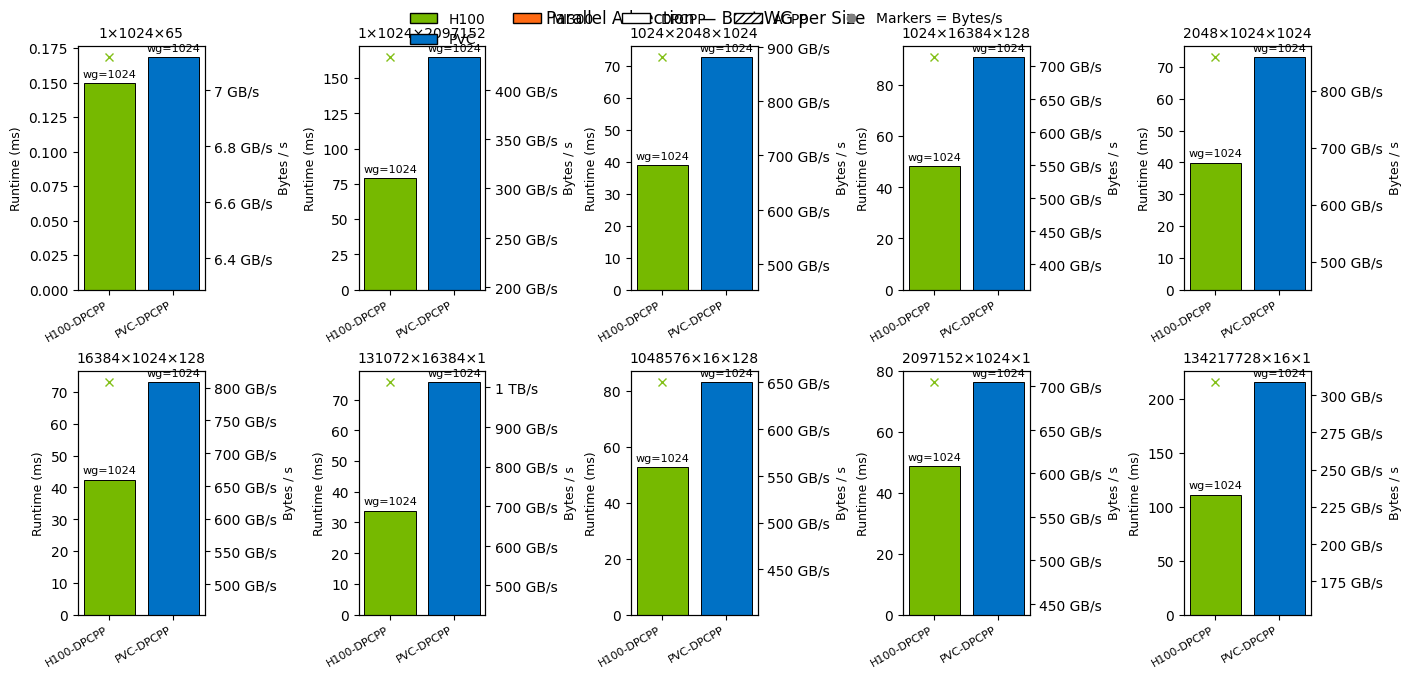

In [2]:

import json, glob, re, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

DATA_DIR = Path("parallel-adv")

# ---- Appearance (consistent house style) ----
HW_STYLE = {
    "h100":  {"color": "#76B900", "marker": "x", "order": 0},
    "pvc":   {"color": "#0071C5", "marker": "^", "order": 1},
    "mi300": {"color": "#FF6A13", "marker": ".", "order": 2},
}
IMPL_HATCH = {"dpcpp": "", "acpp": "////"}  # solid vs hatched bars

BAR_WIDTH = 0.8
RUNTIME_LABEL = "Runtime (ms)"
THRPT_LABEL  = "Bytes / s"
TITLE = "Parallel Advection — Best WG per Size"
FIGSIZE = (14, 6.5)  # 2 x 5 grid of small multiples

# ---- Helpers ----
def parse_meta_from_filename(p: Path):
    """Extract hardware & impl from file name like: advection_h100_dpcpp.json"""
    m = re.search(r"(h100|pvc|mi300).*(dpcpp|acpp)", p.stem, re.IGNORECASE)
    if not m:
        raise ValueError(f"Cannot parse hardware/impl from {p.name}")
    hw = m.group(1).lower()
    impl = m.group(2).lower()
    return hw, impl

def load_one_json(p: Path) -> pd.DataFrame:
    with open(p, "r") as f:
        raw = json.load(f)
    df = pd.json_normalize(raw["benchmarks"])
    # Keep only aggregate rows we care about
    df = df[(df["run_type"] == "aggregate")]
    # We need time & bytes, so keep both mean & stddev aggregates
    df = df[df["aggregate_name"].isin(["mean", "stddev"])]
    # Retain only rows that correspond to the 'real_time' run_name to avoid mixing other metrics
    df = df[df["run_name"].str.contains(r"/real_time$", regex=True)]
    # Attach meta
    hw, impl = parse_meta_from_filename(p)
    df["hardware"] = hw
    df["impl"] = impl
    # Size & WG
    # Use integer-safe casting (NaNs for stddev rows handled later by ffill within a run)
    for col in ["n0", "n1", "n2", "pref_wg_size"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    # Build a size label
    df["size_tuple"] = list(zip(df["n0"].round().astype("Int64"),
                                df["n1"].round().astype("Int64"),
                                df["n2"].round().astype("Int64")))
    df["size_label"] = df["size_tuple"].apply(lambda t: f"{t[0]}×{t[1]}×{t[2]}" if pd.notna(t[0]) else "unknown")
    return df

def pick_best_wg(df: pd.DataFrame) -> pd.DataFrame:
    """
    From a dataframe containing mean & stddev aggregates for many WG sizes,
    pick the WG with min mean real_time for each (hardware, impl, size).
    Return rows with columns for runtime mean/std and bytes mean/std, plus WG.
    """
    # Separate mean/std rows to pivot easier
    means = df[df["aggregate_name"] == "mean"].copy()
    stds  = df[df["aggregate_name"] == "stddev"].copy()

    # For safety, align stds to their corresponding (run_name, hardware, impl, WG, size)
    key_cols = ["hardware", "impl", "size_label", "pref_wg_size"]
    sel_cols = key_cols + ["real_time", "bytes_per_second"]
    means = means[sel_cols].rename(columns={"real_time":"rt_mean", "bytes_per_second":"bps_mean"})
    stds  = stds[sel_cols].rename(columns={"real_time":"rt_std",  "bytes_per_second":"bps_std"})

    merged = pd.merge(means, stds, on=key_cols, how="left")

    # Pick best WG: min runtime mean per (hardware, impl, size)
    idx = merged.groupby(["hardware","impl","size_label"])["rt_mean"].idxmin()
    best = merged.loc[idx].copy()

    # Clean WG label
    best["wg"] = best["pref_wg_size"].round().astype(int)

    # Sort hardware order for consistent plotting
    best["hw_order"] = best["hardware"].map({k:v["order"] for k,v in HW_STYLE.items()})
    best = best.sort_values(["size_label","hw_order","impl"])

    return best

# ---- Load all files ----
files = sorted(glob.glob(str(DATA_DIR / "*.json")))
if not files:
    raise FileNotFoundError(f"No JSON files found in {DATA_DIR}")

dfs = []
for fp in files:
    try:
        dfs.append(load_one_json(Path(fp)))
    except Exception as e:
        print(f"Skip {fp}: {e}")
if not dfs:
    raise RuntimeError("No valid files parsed.")
all_df = pd.concat(dfs, ignore_index=True)

best = pick_best_wg(all_df)

# Determine the 10 size panels. If more than 10 exist, take the first 10 by sorted natural order.
unique_sizes = sorted(best["size_label"].unique(), key=lambda s: tuple(int(x) for x in re.split(r"[×x]", s)))
if len(unique_sizes) < 10:
    # If fewer than 10 sizes present, pad with placeholders to keep layout, but plot only available ones.
    pass
sizes_for_grid = unique_sizes[:10]

# ---- Plot (2 x 5 small histograms) ----
nrows, ncols = 2, 5
fig, axes = plt.subplots(nrows, ncols, figsize=FIGSIZE, constrained_layout=True)
axes = axes.ravel()

# consistent y formatting
eng_fmt = EngFormatter(unit="B/s")  # for bytes/s on right axis

for ax, size_lbl in zip(axes, sizes_for_grid):
    sub = best[best["size_label"] == size_lbl].copy()
    if sub.empty:
        ax.axis("off")
        continue

    # Prepare positions: one bar per (hardware,impl). We keep grouped but single series (best WG only).
    # Build labels like 'H100-DPCPP', 'PVC-DPCPP', etc.
    sub["bar_label"] = sub.apply(lambda r: f"{r['hardware'].upper()}-{r['impl'].upper()}", axis=1)

    # Keep a deterministic order: by hardware, then impl
    sub = sub.sort_values(["hw_order","impl"])
    x = np.arange(len(sub))
    colors = [HW_STYLE[r.hardware]["color"] for _, r in sub.iterrows()]
    hatches = [IMPL_HATCH.get(r.impl, "") for _, r in sub.iterrows()]

    # Bars = runtime mean with stddev
    y_rt = sub["rt_mean"].values
    yerr_rt = sub["rt_std"].values if "rt_std" in sub and sub["rt_std"].notna().any() else None
    bars = ax.bar(x, y_rt, BAR_WIDTH, color=colors, edgecolor="black", linewidth=0.7,
                  yerr=yerr_rt, capsize=3, error_kw=dict(alpha=0.7))

    # Apply hatching for impl
    for patch, hatch in zip(bars, hatches):
        patch.set_hatch(hatch)

    # Text above bars = best WG  (use annotate for offsets)
    for xi, yi, wg in zip(x, y_rt, sub["wg"].values):
        ax.annotate(
            f"wg={wg}",
            xy=(xi, yi),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
        )


    # Right axis = throughput markers with stddev
    ax2 = ax.twinx()
    y_bps = sub["bps_mean"].values
    yerr_bps = sub["bps_std"].values if "bps_std" in sub and sub["bps_std"].notna().any() else None
    markers = [HW_STYLE[r.hardware]["marker"] for _, r in sub.iterrows()]
    for xi, yi, c, m, eb in zip(x, y_bps, colors, markers, (yerr_bps if yerr_bps is not None else [None]*len(x))):
        ax2.errorbar([xi], [yi], yerr=None if eb is None or (isinstance(eb, float) and math.isnan(eb)) else [[eb],[eb]],
                     fmt=m, color=c, markersize=6, capsize=3, elinewidth=1, alpha=0.9)

    # Ax cosmetics
    ax.set_title(size_lbl, fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels(sub["bar_label"].tolist(), rotation=30, ha="right", fontsize=8)
    ax.set_ylabel(RUNTIME_LABEL, fontsize=9)
    ax2.set_ylabel(THRPT_LABEL, fontsize=9)
    ax2.yaxis.set_major_formatter(eng_fmt)

# Hide any leftover axes if < 10 sizes
for j in range(len(sizes_for_grid), len(axes)):
    axes[j].axis("off")

# Build a combined legend (hardware colors + impl hatches + throughput markers note)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

hw_patches = [Patch(facecolor=HW_STYLE[hw]["color"], edgecolor="black", label=hw.upper()) for hw in ["h100","pvc","mi300"]]
impl_patches = [Patch(facecolor="white", edgecolor="black", hatch=IMPL_HATCH[k], label=k.upper()) for k in ["dpcpp","acpp"]]
throughput_proxy = Line2D([0],[0], marker='o', color='gray', linestyle='None', label="Markers = Bytes/s")

handles = hw_patches + impl_patches + [throughput_proxy]
fig.legend(handles=handles, loc="upper center", ncol=5, frameon=False)

fig.suptitle(TITLE, fontsize=12, y=1.02)
plt.show()
